# Phrase grounding

This notebook demonstrates the usage of the BioViL-T image and text models in a multimodal phrase grounding setting.
Given a chest X-ray and a radiology text phrase, the joint model grounds the phrase in the image, i.e., highlights the regions of the image that share features similar to the phrase.
Please refer to [our ECCV and CVPR papers](https://hi-ml.readthedocs.io/en/latest/multimodal.html#credit) for further details.

The notebook can also be run on Binder without the need of any coding or local installation:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/microsoft/hi-ml/HEAD?labpath=hi-ml-multimodal%2Fnotebooks%2Fphrase_grounding.ipynb)

This demo is solely for research evaluation purposes, not intended to be a medical product or clinical use.

## Installation

In [1]:
pip install pants-jupyter-plugin==0.0.6

Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext pants_jupyter_plugin

## Setup

Let's first install the `hi-ml-multimodal` Python package, which will allow us to import the `health_multimodal` Python module.

In [2]:
%%bash
cp /opt/homebrew/bin/pants $(pwd)/../pants

In [3]:
%pants_repo /Users/rajatrasal/Documents/cxr-generation/

Using pants 2.17.0 in repo at: /Users/rajatrasal/Documents/cxr-generation/


In [4]:
%requirements_load torch Cython
%pants_load src/health_multimodal:pex

HTML(value='<style>.nb-console-output-jlKuy { background-color: black;} .nb-console-output-jlKuy pre { color: …

Accordion(children=(Output(layout=Layout(height='300px', overflow_y='scroll'), outputs=({'output_type': 'displ…

HTML(value='<style>.nb-console-output-OIjJh { background-color: black;} .nb-console-output-OIjJh pre { color: …

Accordion(children=(Output(layout=Layout(height='300px', overflow_y='scroll'), outputs=({'output_type': 'displ…

HTML(value='<style>.nb-console-output-JIOCY { background-color: black;} .nb-console-output-JIOCY pre { color: …

Accordion(children=(Output(layout=Layout(height='300px', overflow_y='scroll'), outputs=({'output_type': 'displ…

HTML(value='<style>.nb-console-output-edRuh { background-color: black;} .nb-console-output-edRuh pre { color: …

Accordion(children=(Output(layout=Layout(height='300px', overflow_y='scroll'), outputs=({'output_type': 'displ…

In [5]:
from typing import List, Tuple

import tempfile
from pathlib import Path

import torch
from IPython.display import display, Markdown

from health_multimodal.common import plot_phrase_grounding_similarity_map
from health_multimodal.text import get_bert_inference
from health_multimodal.text.utils import BertEncoderType
from health_multimodal.image import get_image_inference
from health_multimodal.image.utils import ImageModelType
from health_multimodal.vlp import ImageTextInferenceEngine

## Load multimodal model

Load the text and image models from [Hugging Face 🤗](https://aka.ms/biovil-models) and instantiate the inference engines:

In [6]:
text_inference = get_bert_inference(BertEncoderType.BIOVIL_T_BERT)
image_inference = get_image_inference(ImageModelType.BIOVIL_T)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'CXRBertTokenizer'.
You are using a model of type bert to instantiate a model of type cxr-bert. This is not supported for all configurations of models and can yield errors.


Using downloaded and verified file: /var/folders/w8/tf3tfq_n47x3bf475q4m68440000gn/T/biovil_t_image_model_proj_size_128.pt


/Users/rajatrasal/.cache/pants_jupyter_plugin/pex/venvs/5c209566462d4eaf6cbc60531532035aeb7ab3e6/pex.pex/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Instantiate the joint inference engine:

In [7]:
image_text_inference = ImageTextInferenceEngine(
    image_inference_engine=image_inference,
    text_inference_engine=text_inference,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_text_inference.to(device)

## Helper visualization functions

In [8]:
TypeBox = Tuple[float, float, float, float]

def plot_phrase_grounding(image_path: Path, text_prompt: str, bboxes: List[TypeBox]) -> None:
    similarity_map = image_text_inference.get_similarity_map_from_raw_data(
        image_path=image_path,
        query_text=text_prompt,
        interpolation="bilinear",
    )
    plot_phrase_grounding_similarity_map(
        image_path=image_path,
        similarity_map=similarity_map,
        bboxes=bboxes
    )

def plot_phrase_grounding_from_url(image_url: str, text_prompt: str, bboxes: List[TypeBox]) -> None:
    image_path = Path(tempfile.tempdir, "downloaded_chest_xray.jpg")
    !curl -s -L -o {image_path} {image_url}
    plot_phrase_grounding(image_path, text_prompt, bboxes)

## Inference

We will run inference on a chest X-ray from [Open-i](https://openi.nlm.nih.gov/detailedresult?img=CXR111_IM-0076-1001&req=4), but any other chest X-ray image in DICOM or JPEG format can be used for research purposes.


The ground-truth bounding box annotation for the phrase *Left basilar consolidation seen* is shown in the middle figure (in black).

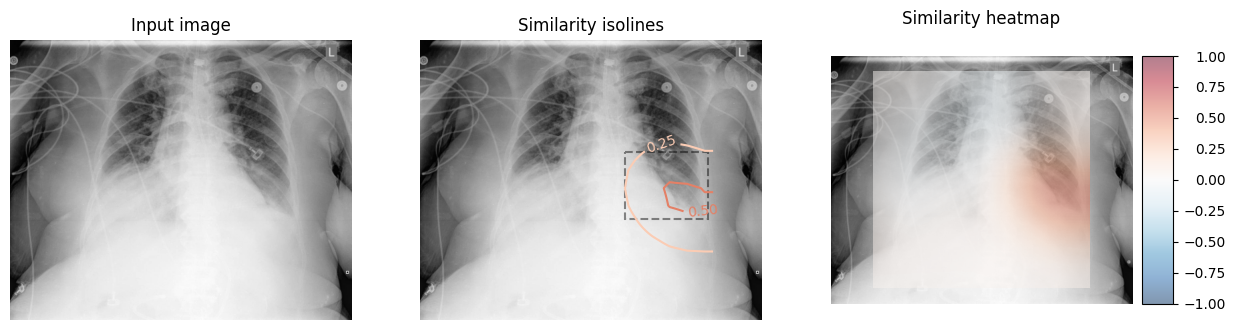

In [9]:
image_url = "https://openi.nlm.nih.gov/imgs/512/242/1445/CXR1445_IM-0287-4004.png"
text_prompt = "Left basilar consolidation seen"
# Ground-truth bounding box annotation(s) for the input text prompt
bboxes = [
    (306, 168, 124, 101),
]

text = (
    'The ground-truth bounding box annotation for the phrase'
    f' *{text_prompt}* is shown in the middle figure (in black).'
)

display(Markdown(text))
plot_phrase_grounding_from_url(image_url, text_prompt, bboxes)